In [1]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split


pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [3]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,...,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,...,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,...,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,...,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.shape

(1460, 81)

In [6]:
test.shape

(1459, 80)

In [7]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [10]:
train.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [11]:
from scipy import stats

In [29]:
train[train.columns[train.dtypes!=object]].skew()

Id                0.000000
MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
S

In [31]:
train[train.columns[train.dtypes!=object]].kurt()

Id                -1.200000
MSSubClass         1.580188
LotFrontage       17.452867
LotArea          203.243271
OverallQual        0.096293
OverallCond        1.106413
YearBuilt         -0.439552
YearRemodAdd      -1.272245
MasVnrArea        10.082417
BsmtFinSF1        11.118236
BsmtFinSF2        20.113338
BsmtUnfSF          0.474994
TotalBsmtSF       13.250483
1stFlrSF           5.745841
2ndFlrSF          -0.553464
LowQualFinSF      83.234817
GrLivArea          4.895121
BsmtFullBath      -0.839098
BsmtHalfBath      16.396642
FullBath          -0.857043
HalfBath          -1.076927
BedroomAbvGr       2.230875
KitchenAbvGr      21.532404
TotRmsAbvGrd       0.880762
Fireplaces        -0.217237
GarageYrBlt       -0.418341
GarageCars         0.220998
GarageArea         0.917067
WoodDeckSF         2.992951
OpenPorchSF        8.490336
EnclosedPorch     10.430766
3SsnPorch        123.662379
ScreenPorch       18.439068
PoolArea         223.268499
MiscVal          701.003342
MoSold            -0

In [32]:
train_skew = train[train.columns[train.dtypes!=object]].skew()

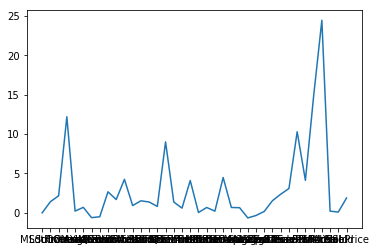

In [33]:
plt.plot(train_skew)

In [40]:
skewed_columns = train_skew.index[train_skew.abs()>1.5]

In [42]:
y_train = train['SalePrice'].values

In [45]:
train.drop(['SalePrice'], axis=1, inplace=True)

In [51]:
all_data = pd.concat([train, test], axis=0)

In [52]:
all_data.shape

(2919, 80)

In [59]:
all_data_skew = all_data[all_data.columns[train.dtypes!=object]].skew()
skewed_columns = all_data_skew.index[all_data_skew.abs()>1.5]

In [60]:
skewed_columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF2', 'LowQualFinSF',
       'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [62]:
np.log(all_data[skewed_columns]).skew()

LotFrontage     -0.889314
LotArea         -0.505542
MasVnrArea            NaN
BsmtFinSF2            NaN
LowQualFinSF          NaN
BsmtHalfBath          NaN
KitchenAbvGr          NaN
WoodDeckSF            NaN
OpenPorchSF           NaN
EnclosedPorch         NaN
3SsnPorch             NaN
ScreenPorch           NaN
PoolArea              NaN
MiscVal               NaN
dtype: float64

In [66]:
stats.skew(np.log(y_train))

0.1212103673013655

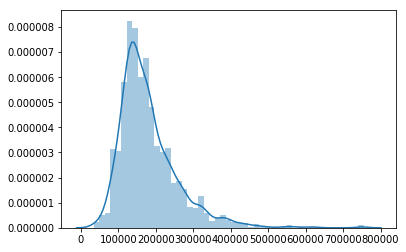

In [68]:
sns.distplot(y_train)

In [73]:
all_data.isnull().sum().sort_values(ascending=False)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
FireplaceQu      1420
LotFrontage       486
GarageCond        159
GarageQual        159
GarageYrBlt       159
GarageFinish      159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
BsmtHalfBath        2
Utilities           2
Functional          2
BsmtFullBath        2
BsmtFinSF1          1
Exterior1st         1
Exterior2nd         1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
SaleType            1
Electrical          1
KitchenQual         1
GarageArea          1
GarageCars          1
HouseStyle          0
LandSlope           0
MSSubClass          0
LotArea             0
Street              0
LotShape            0
LandContour         0
LotConfig           0
Neighborhood        0
OverallQual         0
Condition1          0
Condition2

In [74]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [79]:
all_data.columns[all_data.dtypes==object]

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [82]:
all_data[all_data.columns[all_data.dtypes==object]].isnull().sum().sort_values(ascending=False)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
FireplaceQu      1420
GarageCond        159
GarageQual        159
GarageFinish      159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MSZoning            4
Functional          2
Utilities           2
Electrical          1
KitchenQual         1
SaleType            1
Exterior2nd         1
Exterior1st         1
Heating             0
Condition1          0
Street              0
PavedDrive          0
LotShape            0
LandContour         0
LotConfig           0
LandSlope           0
Neighborhood        0
RoofStyle           0
Condition2          0
BldgType            0
HouseStyle          0
HeatingQC           0
RoofMatl            0
ExterQual           0
ExterCond           0
Foundation          0
CentralAir          0
SaleCondition       0
dtype: int64

In [88]:
for col in all_data.columns[all_data.dtypes==object]:
    all_data[col] = all_data[col].factorize()[0]

In [89]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
LotFrontage,486,0.166495
GarageYrBlt,159,0.054471
MasVnrArea,23,0.007879
BsmtFullBath,2,0.000685
BsmtHalfBath,2,0.000685
BsmtFinSF2,1,0.000343
BsmtUnfSF,1,0.000343
TotalBsmtSF,1,0.000343
BsmtFinSF1,1,0.000343
GarageCars,1,0.000343


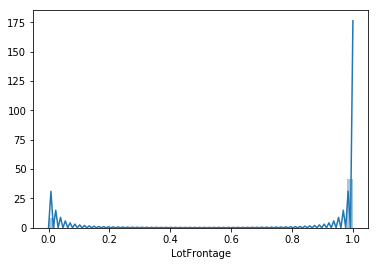

In [95]:
sns.distplot(all_data['LotFrontage'].notnull())

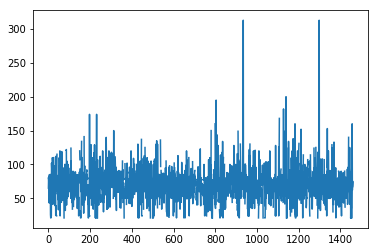

In [98]:
plt.plot(all_data['LotFrontage'])

In [102]:
all_data['LotFrontage'].mean()

69.30579531442663

In [103]:
all_data['LotArea']

0         8450
1         9600
2        11250
3         9550
4        14260
5        14115
6        10084
7        10382
8         6120
9         7420
10       11200
11       11924
12       12968
13       10652
14       10920
15        6120
16       11241
17       10791
18       13695
19        7560
20       14215
21        7449
22        9742
23        4224
24        8246
25       14230
26        7200
27       11478
28       16321
29        6324
30        8500
31        8544
32       11049
33       10552
34        7313
35       13418
36       10859
37        8532
38        7922
39        6040
40        8658
41       16905
42        9180
43        9200
44        7945
45        7658
46       12822
47       11096
48        4456
49        7742
50       13869
51        6240
52        8472
53       50271
54        7134
55       10175
56        2645
57       11645
58       13682
59        7200
60       13072
61        7200
62        6442
63       10300
64        9375
65        9591
66       1

In [97]:
all_data['LotFrontage'].notnull()

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7       False
8        True
9        True
10       True
11       True
12      False
13       True
14      False
15       True
16      False
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24      False
25       True
26       True
27       True
28       True
29       True
30       True
31      False
32       True
33       True
34       True
35       True
36       True
37       True
38       True
39       True
40       True
41       True
42      False
43      False
44       True
45       True
46       True
47       True
48       True
49       True
50      False
51       True
52       True
53       True
54       True
55       True
56       True
57       True
58       True
59       True
60       True
61       True
62       True
63       True
64      False
65       True
66      False
67       True
68       True
69       True
70       True
71    

In [105]:
all_data['GarageYrBlt'].fillna(0, inplace=True)

In [106]:
all_data['MasVnrArea']

0        196.0
1          0.0
2        162.0
3          0.0
4        350.0
5          0.0
6        186.0
7        240.0
8          0.0
9          0.0
10         0.0
11       286.0
12         0.0
13       306.0
14       212.0
15         0.0
16       180.0
17         0.0
18         0.0
19         0.0
20       380.0
21         0.0
22       281.0
23         0.0
24         0.0
25       640.0
26         0.0
27       200.0
28         0.0
29         0.0
30         0.0
31         0.0
32         0.0
33         0.0
34       246.0
35       132.0
36         0.0
37       650.0
38         0.0
39         0.0
40       101.0
41         0.0
42         0.0
43         0.0
44         0.0
45       412.0
46         0.0
47         0.0
48         0.0
49         0.0
50         0.0
51         0.0
52         0.0
53         0.0
54         0.0
55       272.0
56       456.0
57         0.0
58      1031.0
59         0.0
60         0.0
61         0.0
62       178.0
63         0.0
64       573.0
65       344.0
66       2

In [118]:
all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median()

201.0

In [119]:
all_data['MasVnrArea'].fillna(all_data[all_data['MasVnrType']!=1]['MasVnrArea'].median(), inplace=True)

In [120]:
all_data['LotFrontage'].fillna(all_data['LotFrontage'].median(), inplace=True)

In [122]:
all_data.fillna(all_data.mean(), inplace=True)

In [124]:
all_data.skew()

Id                0.000000
MSSubClass        1.376165
MSZoning          2.656140
LotFrontage       1.675713
LotArea          12.829025
Street           15.508104
Alley             4.140513
LotShape          1.262181
LandContour       3.407074
Utilities       -10.372700
LotConfig         1.382671
LandSlope         4.977715
Neighborhood      0.192788
Condition1        3.737025
Condition2       12.239955
BldgType          2.165183
HouseStyle        2.007841
OverallQual       0.197212
OverallCond       0.570605
YearBuilt        -0.600114
YearRemodAdd     -0.451252
RoofStyle         3.647237
RoofMatl          9.382127
Exterior1st       1.206716
Exterior2nd       1.054638
MasVnrType        0.229984
MasVnrArea        2.591806
ExterQual         0.504184
ExterCond         3.809803
Foundation        1.642338
BsmtQual          0.666967
BsmtCond          2.767695
BsmtExposure      1.156361
BsmtFinType1      0.473490
BsmtFinSF1        1.425966
BsmtFinType2      2.881095
BsmtFinSF2        4.148166
B

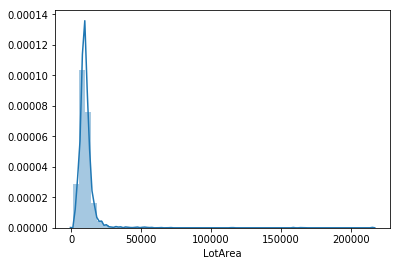

In [133]:
sns.distplot((all_data['LotArea']))

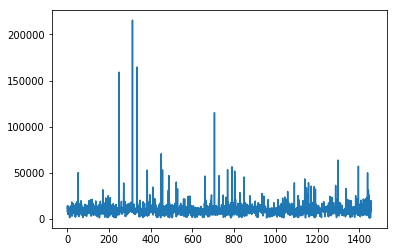

In [134]:
plt.plot((all_data['LotArea']))

In [136]:
all_data['LotArea'].mean()

10168.11408016444

In [138]:
np.percentile(all_data['LotArea'], 95)

17142.899999999998

In [142]:
all_data['LotArea'] = np.clip(all_data['LotArea'], a_min=all_data['LotArea'].min(), a_max=np.percentile(all_data['LotArea'], 95))

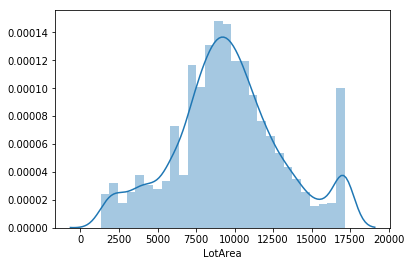

In [143]:
sns.distplot((all_data['LotArea']))

In [148]:
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,0,65.0,8450.0,0,-1,0,0,0,0,0,0,0,0,0,0,7,5,2003,2003,0,0,0,0,0,196.0,0,0,0,0,0,0,0,706.0,0,0.0,150.0,856.0,0,0,0,0,856,854,0,1710,1.0,0.0,2,1,3,1,0,8,0,0,-1,0,2003.0,0,2.0,548.0,0,0,0,0,61,0,0,0,0,-1,-1,-1,0,2,2008,0,0
1,2,20,0,80.0,9600.0,0,-1,0,0,0,1,0,1,1,0,0,1,6,8,1976,1976,0,0,1,1,1,0.0,1,0,1,0,0,1,1,978.0,0,0.0,284.0,1262.0,0,0,0,0,1262,0,0,1262,0.0,1.0,2,0,3,1,1,6,0,1,0,0,1976.0,0,2.0,460.0,0,0,0,298,0,0,0,0,0,-1,-1,-1,0,5,2007,0,0
2,3,60,0,68.0,11250.0,0,-1,1,0,0,0,0,0,0,0,0,0,7,5,2001,2002,0,0,0,0,0,162.0,0,0,0,0,0,2,0,486.0,0,0.0,434.0,920.0,0,0,0,0,920,866,0,1786,1.0,0.0,2,1,3,1,0,6,0,1,0,0,2001.0,0,2.0,608.0,0,0,0,0,42,0,0,0,0,-1,-1,-1,0,9,2008,0,0
3,4,70,0,60.0,9550.0,0,-1,1,0,0,2,0,2,0,0,0,0,7,5,1915,1970,0,0,2,2,1,0.0,1,0,2,1,1,0,1,216.0,0,0.0,540.0,756.0,0,1,0,0,961,756,0,1717,1.0,0.0,1,0,3,1,0,7,0,1,1,1,1998.0,1,3.0,642.0,0,0,0,0,35,272,0,0,0,-1,-1,-1,0,2,2006,0,1
4,5,60,0,84.0,14260.0,0,-1,1,0,0,1,0,3,0,0,0,0,8,5,2000,2000,0,0,0,0,0,350.0,0,0,0,0,0,3,0,655.0,0,0.0,490.0,1145.0,0,0,0,0,1145,1053,0,2198,1.0,0.0,2,1,4,1,0,9,0,1,0,0,2000.0,0,3.0,836.0,0,0,0,192,84,0,0,0,0,-1,-1,-1,0,12,2008,0,0


In [153]:
train = all_data.iloc[:train.shape[0], :]
test = all_data.iloc[train.shape[0]:, :]

In [156]:
test_id = test['Id'].values

In [157]:
del train['Id'], test['Id']

In [162]:
y_train_log = np.log(y_train)

In [163]:
X_tr,X_val,y_tr,y_val = train_test_split(train, y_train_log, shuffle=True, random_state=123, test_size=0.2)

In [164]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'mse', 
               'num_leaves': 2**4,
               'verbose':0 
              }

model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                       valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=100) 
pred_lgb = model_lgb.predict(X_val)
pred_lgb_test = model_lgb.predict(test)

print('Test R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb))

[1]	valid_0's rmse: 0.356456
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 0.328684
[3]	valid_0's rmse: 0.305515
[4]	valid_0's rmse: 0.284106
[5]	valid_0's rmse: 0.265846
[6]	valid_0's rmse: 0.250195
[7]	valid_0's rmse: 0.236145
[8]	valid_0's rmse: 0.223293
[9]	valid_0's rmse: 0.212149
[10]	valid_0's rmse: 0.202381
[11]	valid_0's rmse: 0.193393
[12]	valid_0's rmse: 0.185836
[13]	valid_0's rmse: 0.179256
[14]	valid_0's rmse: 0.172688
[15]	valid_0's rmse: 0.167659
[16]	valid_0's rmse: 0.162492
[17]	valid_0's rmse: 0.157891
[18]	valid_0's rmse: 0.1539
[19]	valid_0's rmse: 0.149483
[20]	valid_0's rmse: 0.146601
[21]	valid_0's rmse: 0.143263
[22]	valid_0's rmse: 0.141231
[23]	valid_0's rmse: 0.138622
[24]	valid_0's rmse: 0.136509
[25]	valid_0's rmse: 0.134725
[26]	valid_0's rmse: 0.132704
[27]	valid_0's rmse: 0.131774
[28]	valid_0's rmse: 0.130777
[29]	valid_0's rmse: 0.129507
[30]	valid_0's rmse: 0.128348
[31]	valid_0's rmse: 0.127508
[32]	valid_0's rms

In [173]:
solution = pd.DataFrame({"id":test_id, "SalePrice":np.exp(pred_lgb_test)})
solution.to_csv("submission_26.csv", index = False)

In [ ]:
for col in skewed_columns:
    sns.distplot(all_data[col])